In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
from torch.nn import MSELoss
import torch.nn.functional as F
import torchmetrics
from torchmetrics import MeanSquaredError,PearsonCorrCoef
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric --no-index --find-links=file:///kaggle/input/torch-geometric
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data,Dataset
from torch_geometric.nn import GCNConv, GATConv,global_mean_pool
from torch_geometric.nn.norm import BatchNorm
from torch.optim.lr_scheduler import StepLR

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Looking in links: file:///kaggle/input/torch-geometric
Processing /kaggle/input/torch-geometric/torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_cluster-1.6.0-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_spline_conv-1.2.1-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_geometric-2.2.0-py3-none-any.whl


In [2]:
dataset=[]
for i in range(0,400):
    dataset.append(torch.load("/kaggle/input/bapst-data-static-structure-in-glasses/graphs/graph"+str(i)+".pt"))
    dataset[i].x=dataset[i].x.type(torch.float32)
    dataset[i].edge_attr=dataset[i].edge_attr.type(torch.float32)

In [3]:
dataset[0]

Data(x=[4096, 1], edge_index=[2, 167710], edge_attr=[167710, 3], y=[4096, 1], pos=[4096, 3], e_pot=0, pair_pot=0, edge_targets=[167710, 1], delta_r_cage=[4096, 1])

In [4]:
train_loader=DataLoader(dataset[:350],batch_size=50,shuffle=True)
test_loader=DataLoader(dataset[350:],batch_size=50,shuffle=False)

In [7]:
class GCN(torch.nn.Module):
    def __init__(self,hidden_dim,heads=8):
        super(GCN,self).__init__()
        torch.manual_seed(12345)
        self.conv1=GCNConv(1,hidden_dim,normalize=True,improved=True)
        self.conv2=GCNConv(hidden_dim,hidden_dim,normalize=True,improved=True)
        self.conv3=GCNConv(hidden_dim,hidden_dim,normalize=True,improved=True)
        self.lin1=torch.nn.Linear(hidden_dim,1)
        
    def forward(self,data):
        x,edge_index,edge_attr,batch=data.x,data.edge_index,F.normalize(data.edge_attr.mean(1),p=2.0,dim=0),data.batch
        x=self.conv1(x,edge_index,edge_attr)
        x=x.relu()
        x=F.dropout(x,p=0.5,training=self.training)
        x=self.conv2(x,edge_index,edge_attr)
        x=x.relu()
        x=F.dropout(x,p=0.5,training=self.training)
        x=self.conv3(x,edge_index,edge_attr)
        x=x.relu()
        x=F.dropout(x,p=0.5,training=self.training)
        x=self.lin1(x)
        return x

In [8]:
pearson_corr=PearsonCorrCoef().to(device)

In [9]:
empty=torch.empty(0)
empty

tensor([])

In [12]:
def evaluate():
    model.eval()
    outs=torch.empty(0).to(device)
    ys=torch.empty(0).to(device)
    for data in test_loader:
        data=data.to(device)
        out=model(data)
        outs=torch.cat((outs,out.flatten()))
        ys=torch.cat((ys,data.y.flatten()))
    pearson=pearson_corr(outs,ys)
    return(pearson.item())

In [13]:
loss_fn=MSELoss()
model=GCN(32).to(device)
print(model)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=5e-4)
scheduler = StepLR(optimizer,step_size=10, gamma=0.1)

evaluate()

train_losses=[]
test_losses=[]
for epoch in range(10):
    if epoch%1==0 and epoch!=0:
        print("epoch:",epoch,"| loss:",train_losses[-1]," | pearson_corr:",evaluate())
    batch_losses=[]
    model.train()
    for data in train_loader:
        data=data.to(device)
        optimizer.zero_grad()
        out=model(data)
        loss=loss_fn(out,data.y)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    train_losses.append(np.mean(batch_losses))
    
    model.eval()
    batch_losses=[]
    for data in test_loader:
        data=data.to(device)
        out=model(data)
        loss=loss_fn(out,data.y)
        batch_losses.append(loss.item())
    test_losses.append(np.mean(batch_losses))
    scheduler.step()

GCN(
  (conv1): GCNConv(1, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (lin1): Linear(in_features=32, out_features=1, bias=True)
)
epoch: 1 | loss: 0.3777825747217451  | pearson_corr: 0.5995856523513794
epoch: 2 | loss: 0.3206470991883959  | pearson_corr: 0.5995855927467346
epoch: 3 | loss: 0.2649789537702288  | pearson_corr: 0.599585771560669
epoch: 4 | loss: 0.21273443315710341  | pearson_corr: 0.5995849370956421
epoch: 5 | loss: 0.17163683686937606  | pearson_corr: 0.5995851755142212
epoch: 6 | loss: 0.14742144090788706  | pearson_corr: 0.5995849967002869
epoch: 7 | loss: 0.13612889179161616  | pearson_corr: 0.5995849967002869
epoch: 8 | loss: 0.12762241597686494  | pearson_corr: 0.5995851755142212
epoch: 9 | loss: 0.12041520965950829  | pearson_corr: 0.5995844602584839


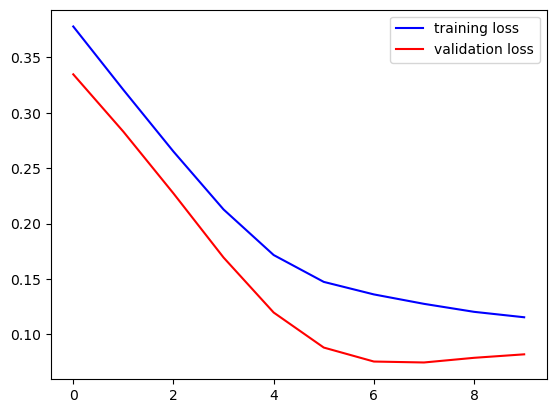

In [14]:
plt.plot(train_losses,color='blue')
plt.plot(test_losses,color='red')
plt.legend(["training loss","validation loss"])
plt.show()

In [15]:
evaluate()

0.5995839238166809